# Lab 5 Report: 
## Create Arthur Conan Doyle AI with RNN

### Name: Sara Reyes

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.distributions import Categorical

In [2]:
from IPython.display import Image # For displaying images in colab jupyter cell

In [3]:
Image('lab5_exercise.png', width = 1000)

## Prepare Data

In [4]:
# First n-characters to use for training
data_size_to_train = 100000

# Load the Sherlock Holmes data up to data_size_to_train
data = open('sherlock.txt', 'r').read()[:data_size_to_train]

# Find the unique characters within the training data
characters = sorted(list(set(data)))

# total number of characters in the training data and number of unique characters
data_size, vocab_size = len(data), len(characters)

print("Data has {} characters, {} unique".format(data_size, vocab_size))

Data has 100000 characters, 75 unique


In [5]:
# Use Python Dictionary to map the characters to numbers and vice versa

character_to_num = { ch:i for i,ch in enumerate(characters) }
num_to_character = { i:ch for i,ch in enumerate(characters) }
print(character_to_num)

{'\n': 0, ' ': 1, '!': 2, '"': 3, "'": 4, '(': 5, ')': 6, ',': 7, '-': 8, '.': 9, '0': 10, '1': 11, '2': 12, '3': 13, '4': 14, '5': 15, '6': 16, '7': 17, '8': 18, '9': 19, ':': 20, ';': 21, '?': 22, 'A': 23, 'B': 24, 'C': 25, 'D': 26, 'E': 27, 'F': 28, 'G': 29, 'H': 30, 'I': 31, 'J': 32, 'K': 33, 'L': 34, 'M': 35, 'N': 36, 'O': 37, 'P': 38, 'Q': 39, 'R': 40, 'S': 41, 'T': 42, 'U': 43, 'V': 44, 'W': 45, 'Y': 46, 'a': 47, 'b': 48, 'c': 49, 'd': 50, 'e': 51, 'f': 52, 'g': 53, 'h': 54, 'i': 55, 'j': 56, 'k': 57, 'l': 58, 'm': 59, 'n': 60, 'o': 61, 'p': 62, 'q': 63, 'r': 64, 's': 65, 't': 66, 'u': 67, 'v': 68, 'w': 69, 'x': 70, 'y': 71, 'z': 72, '¨': 73, 'Ã': 74}


In [6]:
# Use the character_to_num dictionary to map each character in the training dataset to a number

data = list(data)

for i, ch in enumerate(data):
  data[i] = character_to_num[ch]
print(data[:30])

[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 42, 30, 27, 1, 25, 37, 35, 38, 34, 27, 42]


## Define Model

In [7]:
class CharRNN(torch.nn.Module):
    
    def __init__(self, num_embeddings, embedding_dim, input_size, hidden_size, num_layers, output_size):
        
        super(CharRNN, self).__init__()
        
        # Define embedding layer
        # num_embeddings = number of unique characters
        # embedding_dim = size of a vector that encodes each character
        self.embedding = torch.nn.Embedding(num_embeddings, embedding_dim)
        
        # Define vanilla RNN cell
        # num_layers = Number of RNN cells to be stacked for deep-RNN
        # nonlinearity = Activation function to use
        self.rnn = torch.nn.RNN(input_size=input_size, hidden_size=hidden_size, 
                                num_layers=num_layers, 
                                nonlinearity = 'relu')
        
        # decoder layer that takes hidden states as inputs and output probabilities for each character
        # output_size = number of unique characters
        self.decoder = torch.nn.Linear(hidden_size, output_size)
    
    def forward(self, input_seq, hidden_state):
        
        # Forward pass input sequence to embedding layer 
        embedding = self.embedding(input_seq)
        
        # RNN cell takes output of embedding layer + previous hidden state as inputs
        output, hidden_state = self.rnn(embedding, hidden_state)
        
        # Forward pass the RNN cell output to decoder to get the probabilities
        output = self.decoder(output)
        
        # hidden states need to be detached from computation graph to be re-used as input
        return output, hidden_state.detach()

## Define Hyperparameters

In [8]:
# Fix random seed
torch.manual_seed(25)

# Define RNN network
rnn = CharRNN(num_embeddings = vocab_size, embedding_dim = 50, 
              input_size = 50, hidden_size = 600, num_layers = 3, #attempted to keep a compact model
              output_size = vocab_size)

# Define learning rate and epochs
learning_rate = 0.0003
epochs = 50

# Size of the input sequence to be used during training and validation
training_sequence_len = 50
validation_sequence_len = 200    

# Define loss function and optimizer
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(rnn.parameters(), lr=learning_rate)

# add .cuda() for GPU acceleration
rnn

CharRNN(
  (embedding): Embedding(75, 50)
  (rnn): RNN(50, 600, num_layers=3)
  (decoder): Linear(in_features=600, out_features=75, bias=True)
)

## Identify Tracked Values

In [9]:
# Tracking training loss per each input/target sequence fwd/bwd pass
train_loss_list = []

## Train Model

In [10]:
# Convert training data into torch tensor and make it into vertical orientation (N, 1)
# Attach .cuda() if using GPU
data = torch.unsqueeze(torch.tensor(data), dim = 1)

# Training Loop ----------------------------------------------------------------------------------------------------------

for epoch in range(epochs):
    
    # Randomly select a starting character from first 100 characters in training set
    character_loc = np.random.randint(100)
    
    # iteration number to keep track of until the sequence reaches the end of training data
    iteration = 0
    
    # initialize initial hiddens state as None
    hidden_state = None

    while character_loc + training_sequence_len + 1 < data_size: # loop continues until target_seq reaches end of the data
        
        # Define input/target sequence
        input_seq = data[character_loc : character_loc + training_sequence_len]
        target_seq = data[character_loc + 1 : character_loc + training_sequence_len + 1]
        # Pass input sequence and hidden_state to RNN
        output, hidden_state = rnn(input_seq, hidden_state)
        
        # Compute loss between RNN output sequence vs target sequence
        # torch.squeeze removes the column dimension and make them into horizontal orientation
        loss = loss_fn(torch.squeeze(output), torch.squeeze(target_seq))
        
        # Append loss
        train_loss_list.append(loss.item())
        
        # Empty gradient buffer -> backpropagation -> update network
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Update starting character for next sequence
        character_loc += training_sequence_len
        
        # Update iteration number
        iteration += 1
            
    print("Averaged Training Loss for Epoch ", epoch,": ", np.mean(train_loss_list[-iteration:]))
    
    # Sample and generate a text sequence after every epoch --------------------------------------------------------------
    
    #Initialize character location and hidden state for validation
    character_loc = 0
    hidden_state = None
    
    # Pick a random character from the dataset as an initial input to RNN 
    rand_index = np.random.randint(data_size-1)
    input_seq = data[rand_index : rand_index+1]

    print("----------------------------------------")
    with torch.no_grad():
        
        while character_loc < validation_sequence_len: # Loop continues until RNN generated sequence is in desired length
            
            # Pass validation sequence to RNN
            # Note that RNN now uses its previous output character as input
            output, hidden_state = rnn(input_seq, hidden_state)
            
            # Take the softmax of the decoder output to get the probabilities of predicted characters
            output = torch.nn.functional.softmax(torch.squeeze(output), dim=0)
            # Use the  probabilities to sample the output character
            character_distribution = torch.distributions.Categorical(output)
            character_num = character_distribution.sample()
            
            # Convert the character number selected from sampling to actual character and print
            print(num_to_character[character_num.item()], end='')
            
            # Update the input_seq so that it's using the output of the RNN as new input
            input_seq[0][0] = character_num.item()
            
            # Update the character location 
            character_loc += 1

    print("\n----------------------------------------")

Averaged Training Loss for Epoch  0 :  2.148896477542243
----------------------------------------
r?s had of iter, phe hat listerd disting, in,' as the Nabch her han hess of sue,
 ack    
 momestion. Dain--.
 Aftander,' of he, your'cisit has hochels at it as into cratched it, and ayse, and ky sort
----------------------------------------
Averaged Training Loss for Epoch  1 :  1.7567851923189841
----------------------------------------
eet is." 'fearies you our some of Mugnnence!
 soud,' too'in over cent ayy and seen with. 'Apuruster. Were disblonging in one his ashed ib, and sharp, your
 Bound.

 "'He mathpond-qoint, and abort to
 
----------------------------------------
Averaged Training Loss for Epoch  2 :  1.585482399961005
----------------------------------------
ur your head terrow until were your tard. ' om. if thotered if after thing, Rooary not
 it is doon the detective at it, thenes. 'Poan your alone. You you may such wrike.'

 "Leside of anieon enow toom
--------------------

## Visualize & Evaluate Model

In [1]:
# Print a validation text sequence that most closely resembles Sherlock Holmes style
print(" As As an incomparably lazy an instant. He reminiscench and water?'There's more with then thinks had tocold you made our wag inst., and done. Aminent. The detective seated himself he isaway in")

 As As an incomparably lazy an instant. He reminiscench and water?'There's more with then thinks had tocold you made our wag inst., and done. Aminent. The detective seated himself he isaway in


In [12]:
# Import seaborn for prettier plot
import seaborn as sns

sns.set(style = 'whitegrid', font_scale = 2.5)

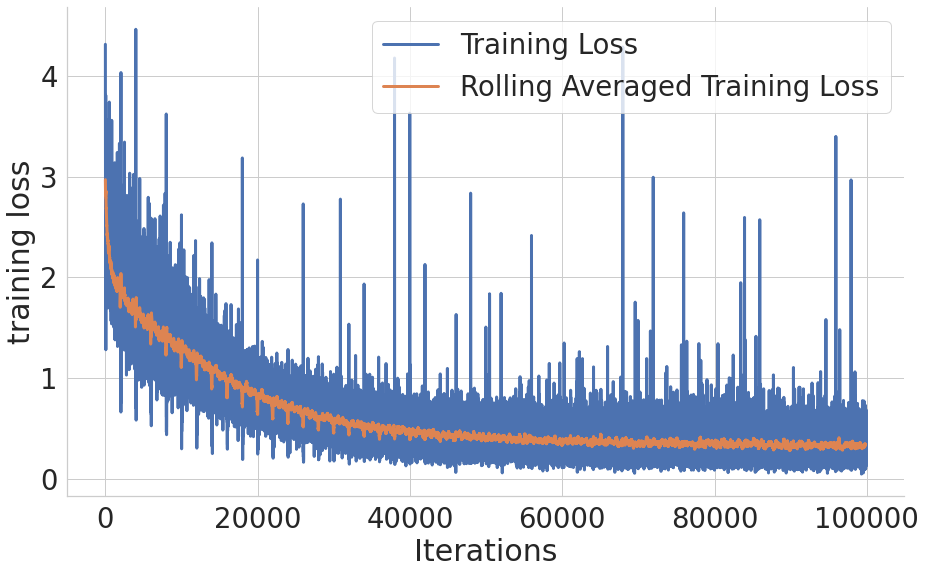

In [13]:
# Plot the training loss and rolling mean training loss with respect to iterations
# Feel free to change the window size
plt.figure(figsize = (15, 9))

plt.plot(train_loss_list, linewidth = 3, label = 'Training Loss')
plt.plot(np.convolve(train_loss_list, np.ones(100), 'valid') / 100, 
         linewidth = 3, label = 'Rolling Averaged Training Loss')
plt.ylabel("training loss")
plt.xlabel("Iterations")
plt.legend()
sns.despine()